# Apply Encoder of Transformer Model (Self Attention) to Explore RNA-Protein Binding

In [25]:
import pandas as pd
import tensorflow as tf
from keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline, make_pipeline
import datetime

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

## Data preparation

In [26]:
df_preprocess = pd.read_csv("data/Result_Structure.csv")
df = df_preprocess[df_preprocess["Qc"]!=1]
df.head()

,Sequence,Structure,MFE,K,KA,RKA,Qc,sevenMer
0,GGAUCCAUUCAAAAAAAGAACGGAUCC,((((((.(((.......))).)))))),-10.5,4.971544,0.201145,0.395847,0,AAAAAAA
1,GGAUCCAUUCAAAAAACGAACGGAUCC,((((((.(((.......))).)))))),-10.5,4.514383,0.221514,0.435934,0,AAAAAAC
2,GGAUCCAUUCAAAAAAGGAACGGAUCC,((((((.(((.......))).)))))),-10.4,3.609146,0.277074,0.545273,0,AAAAAAG
3,GGAUCCAUUCAAAAAAUGAACGGAUCC,((((((.((((.....)))).)))))),-11.7,6.607685,0.151339,0.297831,0,AAAAAAU
4,GGAUCCAUUCAAAAACAGAACGGAUCC,((((((.(((.......))).)))))),-10.5,3.221327,0.310431,0.610919,0,AAAAACA


## Set hyper parameters

In [27]:
seq_length=7
num_layers=1
d_model=9
num_heads=3
dff=64

## Functions to handle the RNA Inputs

In [28]:
def cutWord(x, window=1, length = seq_length):
    seq2word = []
    for i in range(length):
        seq2word.append(x[i*window:i*window+window])
    return " ".join(seq2word)

def RKA_bin(x):
    if x >= 0.8:
        return(1)
    else:
        return(0)

def MFE_bin(x):
    if x >= -14.:
        return(1)
    else:
        return(0)

## Normalization

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(df[["RKA"]]))

df["RKA_norm"] = scaler.transform(df[["RKA"]])
df[["RKA_logplus1"]] = df[["RKA"]].apply(lambda x: np.log(1+x))

MinMaxScaler()


<Axes: ylabel='Count'>

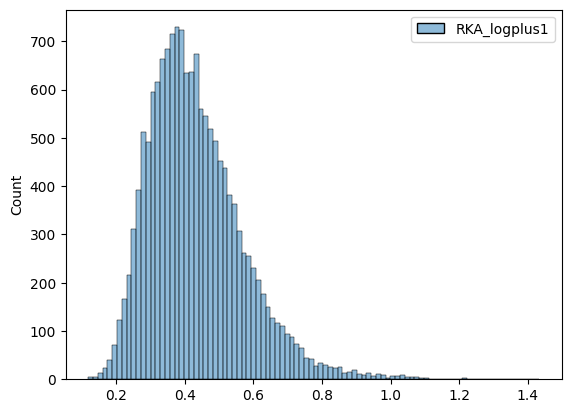

In [30]:
sns.histplot(df[["RKA_logplus1"]])

## Create dataset for Tensorflow model

In [31]:
df["RKA_level"] = df.RKA.apply(RKA_bin)
df["MFE_level"] = df.RKA.apply(RKA_bin)
target = df[["MFE_level","RKA_level"]].copy()
sequences = df[["sevenMer"]].copy()
seq_spaced = sequences.applymap(cutWord)

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=d_model, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int')
vectorize_layer.adapt(seq_spaced)

#Divide to train and test
X_train, X_test, y_train, y_test = train_test_split(seq_spaced, df["RKA_logplus1"], test_size=0.33, random_state=42)
#vec_seq = vectorize_layer(X_train)
#seq_database = v
all_vec_seq = vectorize_layer(X_train)
all_vec_seq = tf.data.Dataset.from_tensor_slices(all_vec_seq)
#target_database = tf.data.Dataset.from_tensor_slices(y_train)
target_database = tf.data.Dataset.from_tensor_slices(y_train)
x_test_database = vectorize_layer(X_test)
x_test_database = tf.data.Dataset.from_tensor_slices(x_test_database)
y_test_database = tf.data.Dataset.from_tensor_slices(y_test)


In [32]:
#train_set = tf.data.Dataset.zip((seq_database, target_database))
train_set = tf.data.Dataset.zip((all_vec_seq, target_database))
test_dataset = tf.data.Dataset.zip((x_test_database, y_test_database))
real_train_set = train_set.batch(50).shuffle(50)
test_dataset = test_dataset.batch(50)
#next(iter(train_set.batch(10)))

## Build Encoder of Transformer model

### Self attention

In [33]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True) # Shape = (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # calculate matmul_qk_v
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights, matmul_qk

#create multi-head attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        #Because for multi-head, head number * depth = multi-head
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #Set layers for q, k, v
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) # shape = (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights, matmul_qk= scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights, matmul_qk

### Fully connected layer and Encoder layer

In [34]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])
        
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #define layers
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):

        attn_output, attn_weight, matmul_qk = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weight, matmul_qk


### Position Encoding

In [35]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2*(i/2))/np.float32(d_model))
    return pos*angle_rate

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :]
                            ,d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [36]:
positional_encoding(1, 9)

<tf.Tensor: shape=(1, 1, 9), dtype=float32, numpy=array([[[0., 1., 0., 1., 0., 1., 0., 1., 0.]]], dtype=float32)>

### Encoder

In [37]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers #how many encoder layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.attention_weights = {}
        self.matmul_qks = {}
        
    def call(self, x, training, mask=None):
        #attention_weights = {}
        #encoding and position encoding
        seq_len = tf.shape(x)[1]
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block, matmul_qk = self.enc_layers[i](x, training, mask)
            self.attention_weights[f'attentions_{i+1}'] = block
            self.matmul_qks[f'matmul_qk_{i+1}'] = matmul_qk
            
        #attention_weights[f'decoder_layer{i+1}_block'] = block
        return x, block # (batch_size, input_seq_len, d_model)
    
    def get_attention(self):
        return self.attention_weights
    def get_matmul_qks(self):
        return self.matmul_qks

### Test of Encoder

In [38]:
sample_encoder = Encoder(num_layers=2, d_model=5, num_heads=1,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=24)
temp_input = vectorize_layer(seq_spaced)
#temp_input = tf.random.uniform((3, 24), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input[22:29], training=False, mask=None)
sample_encoder_output[0].shape

TensorShape([7, 7, 5])

## Create model

In [39]:
def create_model(seq_length, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    input = tf.keras.Input(shape=(seq_length,))
    x , aws= Encoder(num_layers, d_model, num_heads, dff,
                input_vocab_size, maximum_position_encoding, rate=0.1)(input)
    x = tf.keras.layers.Reshape((seq_length*d_model,))(x)
    x = tf.keras.layers.Dense(seq_length, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    output = tf.squeeze(x)
    
    return tf.keras.Model(inputs=input, outputs=output)
    

In [40]:
model = create_model(seq_length=seq_length, num_layers= num_layers, d_model=d_model, num_heads=num_heads,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=7)
p = vectorize_layer(seq_spaced.iloc[17])
model(p)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5694194>

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 encoder_3 (Encoder)         ((None, 7, 9),            1711      
                              (None, 3, None, None))             
                                                                 
 reshape_1 (Reshape)         (None, 63)                0         
                                                                 
 dense_38 (Dense)            (None, 7)                 448       
                                                                 
 dense_39 (Dense)            (None, 1)                 8         
                                                                 
 tf.compat.v1.squeeze_1 (TFO  None                     0         
 pLambda)                                                  

## Test our model to see if it can work and get the attention matrix

2023-10-28 22:26:34.700340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [10354]
	 [[{{node Placeholder/_2}}]]
2023-10-28 22:26:34.700460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [10354]
	 [[{{node Placeholder/_2}}]]


<Axes: >

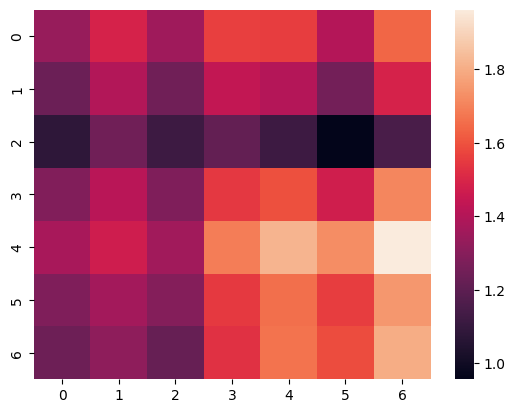

In [42]:
for i in real_train_set.take(1):
    q = model(i[0])
att = model.layers[1].get_attention()['attentions_1']
qk = model.layers[1].get_matmul_qks()['matmul_qk_1']
#forheat = tf.squeeze(att).numpy()
sns.heatmap(qk[(0,0)])

## Custom Schedule/ Accuracy/ Loss functions

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
#optimizer = tf.keras.optimizers.Adam()

#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
loss_object = loss=tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return tf.reduce_sum(loss_)


def accuracy_function(real, pred):
    accuracies = loss_object(real, pred)
    #accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.keras.losses.MeanAbsoluteError(real, pred)
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #accuracies = tf.math.logical_and(mask, accuracies)
    #accuracies = tf.cast(accuracies, dtype=tf.float32)
    #mask = tf.cast(mask, dtype=tf.float32)
    #return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    return tf.reduce_sum(accuracies)

train_metric = tfa.metrics.r_square.RSquare()
test_metric = tfa.metrics.r_square.RSquare()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [44]:
checkpoint_path = "./checkpoints_64_21_pos/new"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

## Customized Train/Test steps

If you face some type mismatch, please use pip install typeguard==2.13.3.
typeguard 3.0.0 version was released recently that's the reason why it's not working.

Source: https://stackoverflow.com/questions/75759597/typeerror-isinstance-arg-2-must-be-a-type-or-tuple-of-types-in-tensorflow-add

In [45]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

#train_step_signature = [
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#    tf.TensorSpec(shape=(None), dtype=tf.int64),
#]


#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    #inp = inp
    target = tar

    with tf.GradientTape() as tape:
        predictions = model(inp, training = True)
        loss = loss_function(target, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)

    train_metric.update_state(target, predictions)
    #result = metric.result()
    #train_accuracy(result)
    #train_accuracy(accuracy_function(target, predictions))
    
def test_step(model, inp, tar):
    #inp = inp
    target = tar
    predictions = model(inp)
    testloss = loss_function(tar, predictions)
    test_loss(testloss)
    test_metric.update_state(target, predictions)

    #result = metric.result()
    #test_accuracy(result)

    #train_accuracy(accuracy_function(target, predictions))

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## Train loop

In [46]:
import time
EPOCHS=100
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()


  for (batch, (inp, tar)) in enumerate(real_train_set):
    train_step(inp, tar)
    if batch % 300 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_metric.result(), step=epoch)

  for (batch, (inp, tar)) in enumerate(test_dataset):
    test_step(model, inp, tar)

  with test_summary_writer.as_default():
    #tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_metric.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Test Loss: {}, Test R^2: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         test_loss.result(),
                         test_metric.result()
                         ))
  #Print out information
 

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

2023-10-28 22:26:34.808375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [10354]
	 [[{{node Placeholder/_2}}]]
2023-10-28 22:26:34.808481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [10354]
	 [[{{node Placeholder/_2}}]]
2023-10-28 22:26:34.844082: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x58f8a3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 22:26:34.844098: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A50

Epoch 1 Batch 0 Loss 0.9444 Accuracy -59.6927


2023-10-28 22:26:39.901022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [5100]
	 [[{{node Placeholder/_2}}]]


Epoch 1, Loss: 0.5041527152061462, Test Loss: 0.18258114159107208, Test R^2: -1.734424114227295
Epoch 2 Batch 0 Loss 0.2390 Accuracy -22.2806
Epoch 2, Loss: 0.1694345772266388, Test Loss: 0.1451597809791565, Test R^2: -0.8753006458282471
Epoch 3 Batch 0 Loss 0.1230 Accuracy -11.9567
Epoch 3, Loss: 0.11510036885738373, Test Loss: 0.1313028782606125, Test R^2: -0.5698368549346924
Epoch 4 Batch 0 Loss 0.0881 Accuracy -8.0412
Epoch 4, Loss: 0.10593315958976746, Test Loss: 0.12377320230007172, Test R^2: -0.4106006622314453
Epoch 5 Batch 0 Loss 0.1123 Accuracy -6.0367
Epoch 5, Loss: 0.10129901766777039, Test Loss: 0.11876802146434784, Test R^2: -0.30883312225341797
Saving checkpoint for epoch 5 at ./checkpoints_64_21_pos/new/ckpt-1
Epoch 5 Loss 0.1013 Accuracy -4.8250
Time taken for 1 epoch: 4.29 secs

Epoch 6 Batch 0 Loss 0.1077 Accuracy -4.8179
Epoch 6, Loss: 0.09954614192247391, Test Loss: 0.11503239721059799, Test R^2: -0.22921538352966309
Epoch 7 Batch 0 Loss 0.1213 Accuracy -4.0033
Epo

## Visualize attentions

In [47]:
df["seq_spaced"] = seq_spaced
def visualize_attention(heads, labels, attention):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1,heads)
    plt.set_cmap('bwr')
    for i in range(heads):
        ax = axs[i]
        cax = ax.matshow(attention[i])
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_xticklabels(labels, rotation=90)
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_yticklabels(labels)
        print(f"head{i}: {tf.reduce_max(attention[i])}")
        print(f"head{i}: {tf.reduce_min(attention[i])}")
    cbar = fig.colorbar(cax)

def plot_attention_head(sequence, attention, heads):
    # The plot is of the attention when a token was generated.
    # # The model didn't generate `<START>` in the output. Skip it.
    labels = [label for label in sequence.to_numpy()[0]]
    #translated_tokens = translated_tokens[1:]
    #ax = plt.gca()
    visualize_attention(heads = heads, labels=labels, attention=attention)
    
   

## Test individual sequence

head0: 3.1803781986236572
head0: -4.424685478210449
head1: 9.652772903442383
head1: -8.575675964355469
head2: 5.864165306091309
head2: -11.110296249389648
sequence:  ['U A G U A G U']
predicted RKA: 0.5630788803100586, real RKA 13003    0.782336
Name: RKA_logplus1, dtype: float64


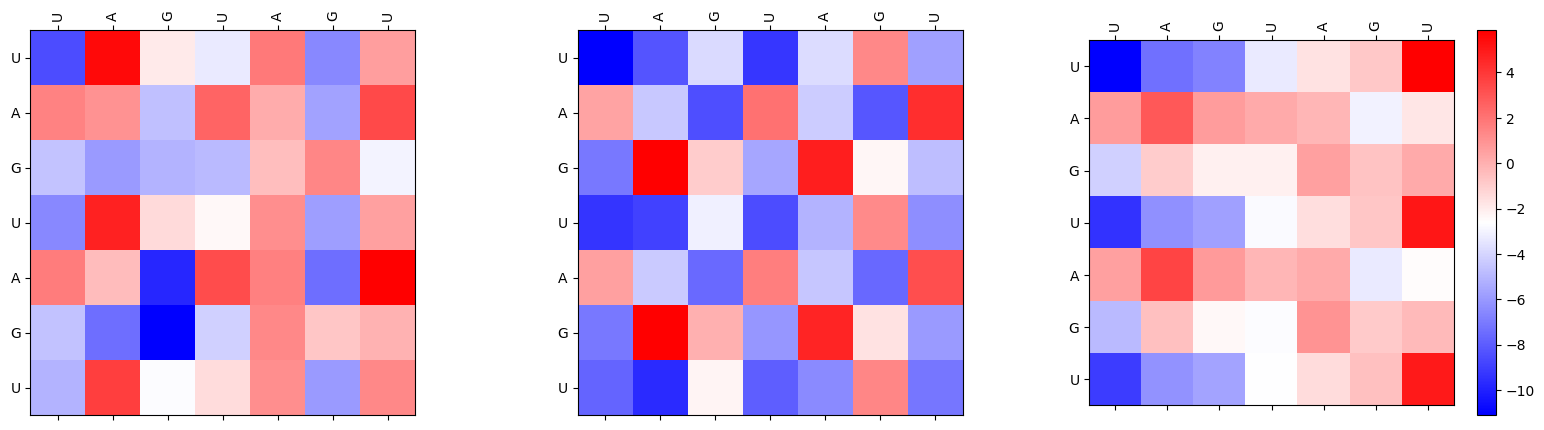

In [48]:
seq = 'UAGUAGU'
sequence_demo = df[df.sevenMer == seq].seq_spaced
rka_for_show = df[df.sevenMer == seq].RKA_logplus1
p = vectorize_layer(sequence_demo)
result = model(p)
att = model.layers[1].get_attention()['attentions_1'][0]
matmul_qk_s = model.layers[1].get_matmul_qks()['matmul_qk_1'][0]
R = sequence_demo.str.split(" ")

plot_attention_head(R,matmul_qk_s, num_heads)
print('sequence: ', sequence_demo.to_numpy())
print(f'predicted RKA: {result.numpy()}, real RKA {rka_for_show}')


head0: 0.5049428343772888
head0: 0.0071404059417545795
head1: 0.9092442393302917
head1: 0.00020627157937269658
head2: 0.9612133502960205
head2: 5.328962652129121e-05
sequence:  ['U A G U A G U']
predicted RKA: 0.5630788803100586, real RKA 13003    0.782336
Name: RKA_logplus1, dtype: float64


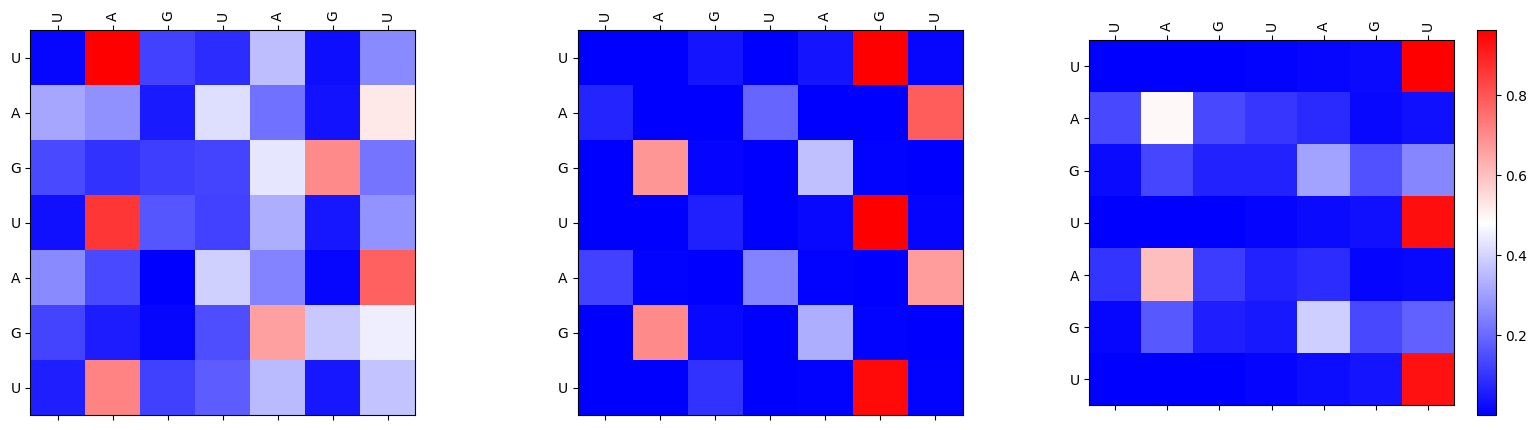

In [49]:
seq = 'UAGUAGU'
sequence_demo = df[df.sevenMer == seq].seq_spaced
rka_for_show = df[df.sevenMer == seq].RKA_logplus1
p = vectorize_layer(sequence_demo)
result = model(p)
att = model.layers[1].get_attention()['attentions_1'][0]
R = sequence_demo.str.split(" ")

plot_attention_head(R,att, num_heads)
print('sequence: ', sequence_demo.to_numpy())
print(f'predicted RKA: {result.numpy()}, real RKA {rka_for_show}')

## Verify the predicted result

In [50]:
result = model.predict(x_test_database.batch(100))
result.shape

51/51 [==============================] - 0s 1ms/step


2023-10-28 22:33:43.889901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [5100,7]
	 [[{{node Placeholder/_0}}]]


(5100,)

<Axes: xlabel='RKA_logplus1'>

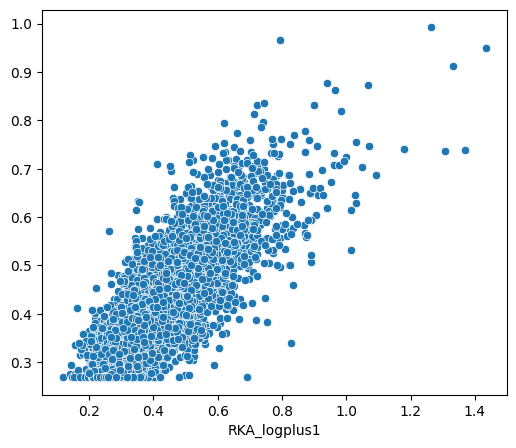

In [51]:
plt.rcParams["figure.figsize"] = (6,5)
sns.scatterplot(x=y_test, y=result)

In [52]:
# Calculate R^2
from sklearn.metrics import r2_score
r2_score(y_test, result)

0.6413234846945735

<Axes: xlabel='RKA_logplus1', ylabel='Count'>

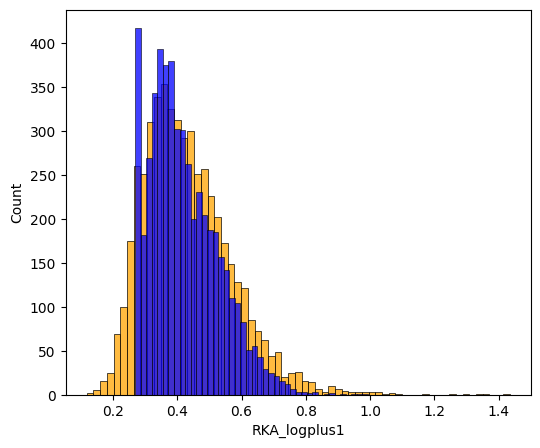

In [53]:
sns.histplot(y_test, color = "orange")
sns.histplot(result, color = "blue")
# # 绘制y_test和result的cdf曲线图
# sns.kdeplot(y_test, cumulative=True)
# sns.kdeplot(result, cumulative=True)
